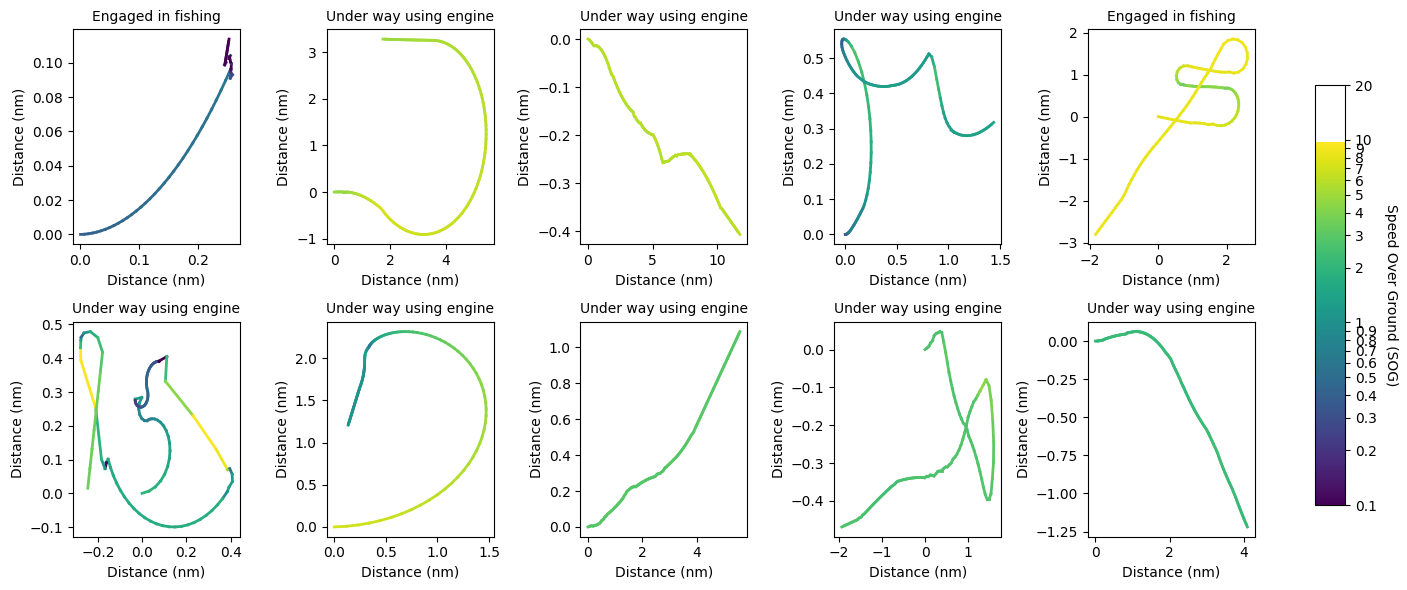

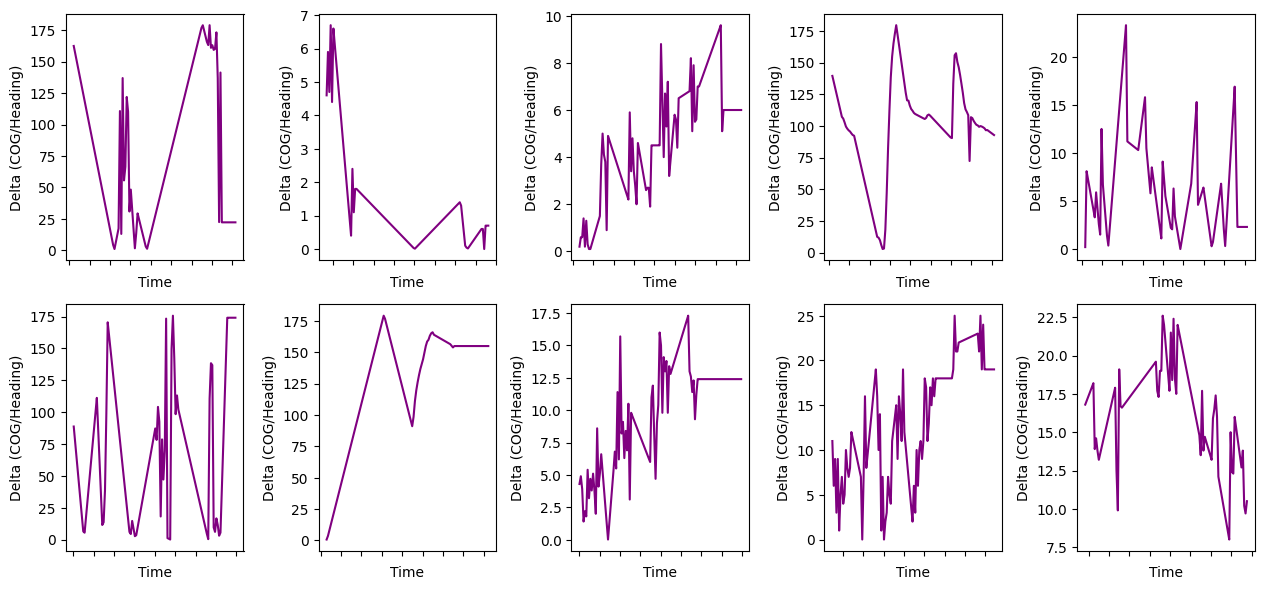

Visualization completed for 10 randomly picked misclassified files, including delta COG-Heading with cyclical correction.


C:\Users\goeck\AppData\Local\Temp\ipykernel_10192\1542763478.py:134: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_delta.show()


In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm
from matplotlib.cm import ScalarMappable
import random

# Define the new misclassified summary file (text file)
misclassified_file = "misclas_2h_LSTM_3_2_run20250223_1.txt"

# Read misclassified summary: each line is a file path
with open(misclassified_file, "r") as f:
    misclassified_files = f.read().splitlines()

# Randomly pick 10 misclassified files
if len(misclassified_files) < 10:
    selected_files = misclassified_files
else:
    selected_files = random.sample(misclassified_files, 10)

# Compute global SOG range across the selected files for consistent color mapping
global_min_sog, global_max_sog = float("inf"), float("-inf")
for file_path in selected_files:
    if os.path.exists(file_path):
        data = pd.read_csv(file_path)
        if 'SOG' in data.columns:
            global_min_sog = min(global_min_sog, data['SOG'].min())
            global_max_sog = max(global_max_sog, data['SOG'].max())

# Ensure valid min/max SOG values
global_min_sog = max(global_min_sog, 0.1)
global_max_sog = max(global_max_sog, 1.0)

# Set up colormap for plotting vessel speeds
norm = LogNorm(vmin=global_min_sog, vmax=global_max_sog)
cmap = plt.cm.viridis
sm = ScalarMappable(cmap=cmap, norm=norm)

# Function to compute angular difference with cyclical correction
def angular_diff(cog, heading):
    diff = np.abs(cog - heading)
    return np.minimum(diff, 360 - diff)

def visualize_vessel_path(file_path, status, ax, ax_delta):
    try:
        data = pd.read_csv(file_path)
        # Check for required columns
        if not {'Timestamp', 'SOG', 'COG', 'Navigational status', 'Heading'}.issubset(data.columns):
            print(f"Skipping {file_path}: Missing required columns.")
            return
        
        # Convert timestamps to datetime objects
        data['Timestamp'] = pd.to_datetime(data['Timestamp'])
        data['time_diff'] = data['Timestamp'].diff().dt.total_seconds() / 3600
        data.loc[0, 'time_diff'] = 0
        
        # Compute cumulative positions from SOG and COG
        data['x'] = data['SOG'] * data['time_diff'] * np.cos(np.deg2rad(data['COG']))
        data['y'] = data['SOG'] * data['time_diff'] * np.sin(np.deg2rad(data['COG']))
        data['x_cum'], data['y_cum'] = data['x'].cumsum(), data['y'].cumsum()
        
        # Plot the vessel path on the primary axis
        for i in range(len(data) - 1):
            ax.plot(
                [data['x_cum'].iloc[i], data['x_cum'].iloc[i + 1]],
                [data['y_cum'].iloc[i], data['y_cum'].iloc[i + 1]],
                color=cmap(norm(data['SOG'].iloc[i])),
                linewidth=2
            )
        
        # Compute the delta between COG and Heading with cyclical correction
        data['delta_COG_Heading'] = angular_diff(data['COG'], data['Heading'])
        if (data['delta_COG_Heading'] > 50).any():
            print(f"Warning: Delta COG/Heading > 50 for file: {file_path}")
        
        # Plot the delta on the secondary axis
        ax_delta.plot(data['Timestamp'], data['delta_COG_Heading'], color='purple')
        ax_delta.set_ylabel('Delta (COG/Heading)')
        ax_delta.set_xlabel('Time', fontsize=10)
        ax_delta.set_xticklabels([])  # Hide x-axis labels for clarity
        
        # Set labels and title for the main plot
        ax.set_xlabel('Distance (nm)')
        ax.set_ylabel('Distance (nm)')
        ax.set_title(f"{status}", fontsize=10)
        
    except Exception as e:
        print(f"Error processing {file_path}: {e}")

# Create subplots for 10 files (2 rows x 5 columns)
cols = 5
rows = 2
fig, axes = plt.subplots(rows, cols, figsize=(15, 3 * rows))
axes = axes.flatten()

# Create secondary axes for the delta plots
fig_delta, axes_delta = plt.subplots(rows, cols, figsize=(15, 3 * rows))
axes_delta = axes_delta.flatten()

# Process each selected misclassified file
for idx, file_path in enumerate(selected_files):
    if idx >= len(axes):
        break  # Safety check in case there are more files than subplot axes
    
    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        continue
    
    data = pd.read_csv(file_path)
    status = data['Navigational status'].iloc[0] if 'Navigational status' in data.columns else 'Unknown'
    visualize_vessel_path(file_path, status, axes[idx], axes_delta[idx])

# Remove any unused subplot axes
for idx in range(len(selected_files), len(axes)):
    fig.delaxes(axes[idx])
for idx in range(len(selected_files), len(axes_delta)):
    fig_delta.delaxes(axes_delta[idx])

# Adjust layout to prevent overlap
fig.tight_layout(rect=[0, 0, 0.85, 1])
fig_delta.tight_layout(rect=[0, 0, 0.85, 1])

# Add a colorbar for the SOG mapping
cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.7])
cbar = plt.colorbar(sm, cax=cbar_ax)
cbar.set_label('Speed Over Ground (SOG)', rotation=270, labelpad=15)
ticks = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20]
cbar.set_ticks(ticks)
cbar.set_ticklabels([f"{t:g}" for t in ticks])

# Display the figures
plt.show()
fig_delta.show()

print("Visualization completed for 10 randomly picked misclassified files, including delta COG-Heading with cyclical correction.")